# Breit Wigner Example of GP Reconstruction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# this needs to be removed when the package is installed
import sys
sys.path.append('../')

import fredipy as fp


## A simple Reconstruction example

### prepare some data

In [26]:
# define breit wigner peak
def get_BW(p, a, m, g):
    return a / (m ** 2 + (np.sqrt(p**2) + g) ** 2)

# define the associates spectral function rho
def get_rho(w, a, m, g):
    return (4 * a * g * w) / (4 * g ** 2 * w ** 2 + (g ** 2 + m ** 2 - w ** 2) ** 2)

# ... and the källen lehmann kernel
def kl_kernel(p, w):
    return w / (w**2 + p**2) / np.pi

In [27]:
# prepare the arrays

w_pred = np.arange(0.1, 10, 0.1)
p = np.linspace(0, 20, 100)

a = 1.6
m = 1
g = 0.8

# the example spectral function
rho = get_rho(w_pred, a, m, g) 

# ... and the associated correlator
G = get_BW(p, a, m, g)

# put some noise on the data
err = 1e-5
G_err = G + err * np.random.randn(len(G))

data = {
    'x': p,
    'y': G_err,
    'dy': err**2}

### do the reconstruction

In [28]:
# use the RBF kernel
kernel = fp.kernels.RadialBasisFunction(0.3, 0.4)
# define the integrator method to use, with upper and lower bounds and number of points
integrator = fp.integrators.Riemann_1D(0, 20, 1000)

# ... and define the operator, the integration with the källen lehmann kernel
integral_op = fp.operators.Integral(kl_kernel, integrator)

# ... and define the full constraint using the date we genrated before
constraints = [fp.constraints.LinearEquality(integral_op, data)]

# now we can define the model using the contraints and the GP kernel
model = fp.models.GaussianProcess(kernel, constraints)

# ... and do a prediction
_rho, _rho_err = model.predict(w_pred)

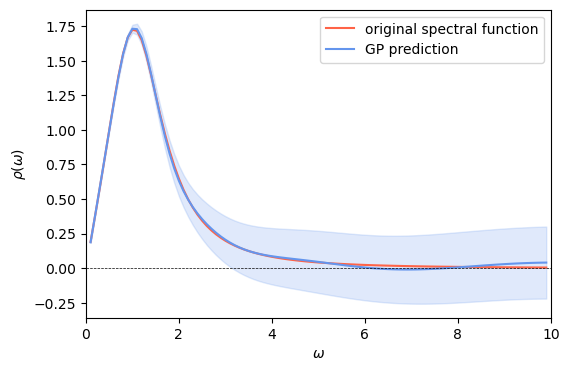

In [29]:
# ... and compare the results with the original spectral function

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(w_pred, rho, color='tomato', label='original spectral function')
ax.plot(w_pred, _rho, color='cornflowerblue', label = 'GP prediction')
ax.fill_between(w_pred.squeeze(), _rho.squeeze() - _rho_err, _rho.squeeze() + _rho_err, color='cornflowerblue', alpha=0.2)

ax.set_xlim((0, 10))
ax.axhline(0, color='black', lw=0.5, ls='--')

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$\rho(\omega)$')

ax.legend();


In [7]:
# we can also compare the prediction of the correlator with the original data
_G, _G_err = model.predict_data()

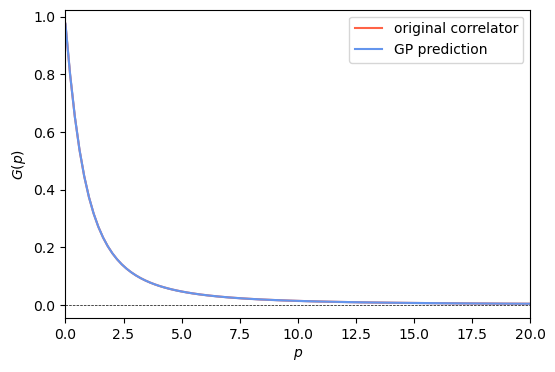

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(p, G_err, color='tomato', label='original correlator')
ax.plot(p, _G, color='cornflowerblue', label='GP prediction')
ax.fill_between(p.squeeze(), _G.squeeze() - _G_err, _G.squeeze() + _G_err, color='cornflowerblue', alpha=0.3)

ax.set_xlim((0, 20))
ax.axhline(0, color='black', lw=0.5, ls='--')

ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$G(p)$')

ax.legend();


### doing simple optimizations

We can use the log-likelihood of the posterior GP to optimize the kernel parameters.

We present a very minimal optimization here. In general, we would not expect convergence using this optimization.

In [9]:
from scipy import optimize

def optimize_kernel_parameters(
        gp: fp.models.GaussianProcess, # a Gaussian Process Model
        guess: list[float],  # some initial guess on the parameters
        bound_min: float = 1e-4 # minimal value for the parameters (we want to avoid 0)
        ):

    # wrapper function
    def optimized_function(params):
        
        gp.set_kernel_params(params)
        return - gp.log_likelihood()
    
    
    num_params = len(guess)
    bounds = [(bound_min, None)]*num_params

    res = optimize.minimize(optimized_function, guess, bounds = bounds, method = 'L-BFGS-B')

    if res.success:
        print(' Optimized parameters are: ', res.x)
        gp.set_kernel_params(res.x)
    else:
        print('No convergence in optimization!')


In [10]:
# do the optimization
optimize_kernel_parameters(model, [0.3, 0.4])

# ... and compute the new spectral function
_rho, _rho_err = model.predict(w_pred)

 Optimized parameters are:  [1.26196692 0.67316604]


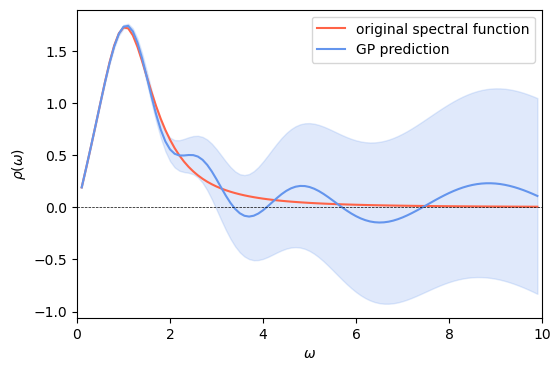

In [11]:
# ... and plot

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(w_pred, rho, color='tomato', label='original spectral function')
ax.plot(w_pred, _rho, color='cornflowerblue', label = 'GP prediction')
ax.fill_between(w_pred.squeeze(), _rho.squeeze() - _rho_err, _rho.squeeze() + _rho_err, color='cornflowerblue', alpha=0.2)

ax.set_xlim((0, 10))
ax.axhline(0, color='black', lw=0.5, ls='--')

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$\rho(\omega)$')

ax.legend();


## Adding more constraints to the model

We can now add more information to the model, in order to increase the accuracy of the prediction.

Here we will give the following examples:

- direct data
- derivative data
- asymptotic information

### adding direct data

In [12]:
# assume we know the spectral function at some points w_direct, with some error
w_direct = np.array([0.1, 0.5, 4, 6, 8, 9])
rho_direct = get_rho(w_direct, a, m, g) + 0.1 * np.random.randn(len(w_direct))

obs_direct = {
    'x': w_direct,
    'y': rho_direct,
    'dy': 0.1**2}

In [13]:
# here we just repeat some steps from before
kernel = fp.kernels.RadialBasisFunction(0.3, 0.4)
integrator = fp.integrators.Riemann_1D(0, 20, 1000)
integral_op = fp.operators.Integral(kl_kernel, integrator)

# ... but now we define the direct data constraint
identity_op = fp.operators.Identity()

# ... and add it to the constraints
constraints = [fp.constraints.LinearEquality(integral_op, data),
               fp.constraints.LinearEquality(identity_op, obs_direct)]

# now we can define the model using the contraints and the GP kernel
model = fp.models.GaussianProcess(kernel, constraints)

# ... and do a prediction
_rho, _rho_err = model.predict(w_pred)

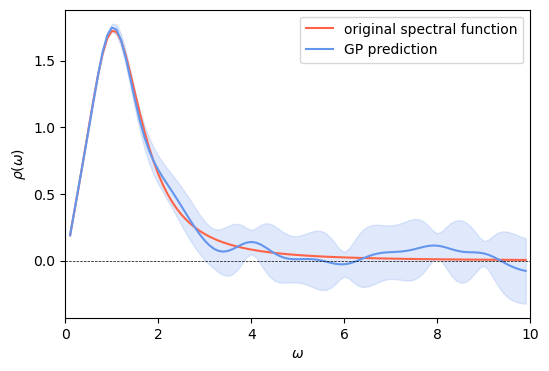

In [14]:
# ... and plot

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(w_pred, rho, color='tomato', label='original spectral function')
ax.plot(w_pred, _rho, color='cornflowerblue', label = 'GP prediction')
ax.fill_between(w_pred.squeeze(), _rho.squeeze() - _rho_err, _rho.squeeze() + _rho_err, color='cornflowerblue', alpha=0.2)

ax.set_xlim((0, 10))
ax.axhline(0, color='black', lw=0.5, ls='--')

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$\rho(\omega)$')

ax.legend();


### adding derivative data

In [15]:
def get_rho_deriv(w, a, m, g):
    # uff
    return (4 * a * g * (g**4 + m**4 + 2 * m**2 * w**2 - 3 * w**4 + 2 * g**2 * (m**2 - w**2))) / (g**4 + (m**2 - w**2)**2 + 2 * g**2 * (m**2 + w**2))**2

In [16]:
# assume we know the spectral function derivative at some points w_deriv, with some error
w_deriv = np.array([1, 1.5, 5, 7, 8, 8.5])
rho_deriv = get_rho_deriv(w_deriv, a, m, g) + 0.1 * np.random.randn(len(w_deriv))

obs_deriv = {
    'x': w_deriv,
    'y': rho_deriv,
    'dy': 0.1**2}

In [17]:
# here we just repeat some steps from before
kernel = fp.kernels.RadialBasisFunction(0.3, 0.4)
integrator = fp.integrators.Riemann_1D(0, 20, 1000)
integral_op = fp.operators.Integral(kl_kernel, integrator)
identity_op = fp.operators.Identity()

# ... but now we define the derivative data constraint
derivative_op = fp.operators.Derivative()

# ... and add it to the constraints
constraints = [fp.constraints.LinearEquality(integral_op, data),
               fp.constraints.LinearEquality(identity_op, obs_direct),
               fp.constraints.LinearEquality(derivative_op, obs_deriv)]

# now we can define the model using the contraints and the GP kernel
model = fp.models.GaussianProcess(kernel, constraints)

# ... and do a prediction
_rho, _rho_err = model.predict(w_pred)

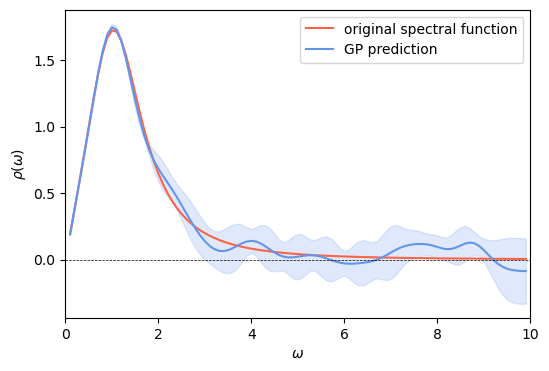

In [18]:
# ... and plot

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(w_pred, rho, color='tomato', label='original spectral function')
ax.plot(w_pred, _rho, color='cornflowerblue', label = 'GP prediction')
ax.fill_between(w_pred.squeeze(), _rho.squeeze() - _rho_err, _rho.squeeze() + _rho_err, color='cornflowerblue', alpha=0.2)

ax.set_xlim((0, 10))
ax.axhline(0, color='black', lw=0.5, ls='--')

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$\rho(\omega)$')

ax.legend();


### adding asymptotics of the spectral function

In [19]:
# define the asymptotic form
def uv_asymptotics(w):
    return 1 / w**3

In [20]:
# here, we now modifiy the kernel,
# first we define the RBF kernel as before
rbf = fp.kernels.RadialBasisFunction(0.3, 0.4)

# ... and then we define the asymptotic kernel
kernel = fp.kernels.AsymptoticKernel(rbf)

# ... add the known asymptotic form
kernel.add_asymptotics(region='UV', asymptotics=uv_asymptotics)
kernel.set_params([1.,3.])

# here we just repeat some steps from before
integrator = fp.integrators.Riemann_1D(0.01, 20, 1000)
integral_op = fp.operators.Integral(kl_kernel, integrator)
identity_op = fp.operators.Identity()
constraints = [fp.constraints.LinearEquality(integral_op, data),
               fp.constraints.LinearEquality(identity_op, obs_direct)] # deriviative of this kernel is not implemented yet

# now we can define the model using the contraints and the asymptotic GP kernel
model = fp.models.GaussianProcess(kernel, constraints)

# ... and do a prediction
_rho, _rho_err = model.predict(w_pred)

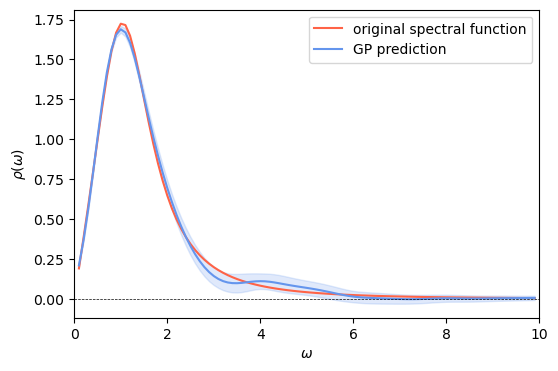

In [21]:
# ... and plot

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(w_pred, rho, color='tomato', label='original spectral function')
ax.plot(w_pred, _rho, color='cornflowerblue', label = 'GP prediction')
ax.fill_between(w_pred.squeeze(), _rho.squeeze() - _rho_err, _rho.squeeze() + _rho_err, color='cornflowerblue', alpha=0.2)

ax.set_xlim((0, 10))
ax.axhline(0, color='black', lw=0.5, ls='--')

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$\rho(\omega)$')

ax.legend();


## Adding an additional dimension to the GP reconstruction

In [22]:
# some ad-hoc 2D extension of BW with some extra parameter k
def get_rho2d(w, k, a, m, g):
    return (4 * a * g * w) / (4 * g ** 2 * w ** 2 + (g ** 2 + m ** 2 - w ** 2) ** 2) * (1 + k**2)

def get_BW2d(p, k, a, m, g):
    return a / (m ** 2 + (np.sqrt(p**2) + g) ** 2) * (1 + k**2)

In [23]:
# prepare the arrays for the 2D case

# ... in k direction
k = np.linspace(0, 2, 3)
# ... and in w direction
w = np.linspace(0.1, 10, 100)

# mesh them together
ww, wk = np.meshgrid(w, k)
w_pred = np.c_[ww.ravel(), wk.ravel()]

# ... and in p direction
p = np.linspace(0.1, 10, 30)
pp, kk = np.meshgrid(p, k)
p_data = np.c_[pp.ravel(), kk.ravel()]

a = 1.6
m = 1
g = 0.8

rho = get_rho2d(w_pred[:,0], w_pred[:,1], a, m, g)
G = get_BW2d(p_data[:,0],p_data[:,1], a, m, g)

err = 1e-4

data2d = {
    'x': p_data,
    'y': G + err * np.random.randn(len(G)),
    'dy': err**2}

In [24]:
# we do the same as before
kernel = fp.kernels.RadialBasisFunction(0.3, [0.4, 0.4])
integrator = fp.integrators.Riemann(0.01, 20, 1000)
integral_op = fp.operators.Integral(kl_kernel, integrator)
constraints = [fp.constraints.LinearEquality(integral_op, data2d)]
model = fp.models.GaussianProcess(kernel, constraints)

# ... and do a prediction
_rho, _rho_err = model.predict(w_pred)

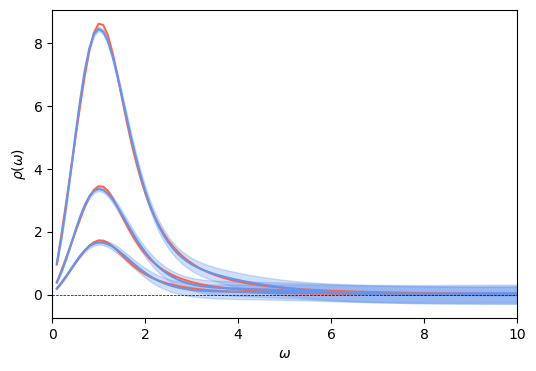

In [25]:
# ... and plot

fig, ax = plt.subplots(figsize=(6, 4))

l = len(w)
_rho = _rho.squeeze()

ax.plot(w, rho[0:l], color='tomato')
ax.plot(w, rho[l:2*l], color='tomato')
ax.plot(w, rho[2*l:3*l], color='tomato')

ax.plot(w, _rho[0:l], color='cornflowerblue')
ax.plot(w, _rho[l:2*l], color='cornflowerblue')
ax.plot(w, _rho[2*l:3*l], color='cornflowerblue')

ax.fill_between(w, _rho[0:l] - _rho_err[0:l],  _rho[0:l] + _rho_err[0:l], color='cornflowerblue', alpha=0.3)
ax.fill_between(w, _rho[l:2*l] - _rho_err[l:2*l],  _rho[l:2*l] + _rho_err[l:2*l], color='cornflowerblue', alpha=0.3)
ax.fill_between(w, _rho[2*l:3*l] - _rho_err[2*l:3*l],  _rho[2*l:3*l] + _rho_err[2*l:3*l], color='cornflowerblue', alpha=0.3)

ax.set_xlim((0, 10))
ax.axhline(0, color='black', lw=0.5, ls='--')

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$\rho(\omega)$');

# ...end